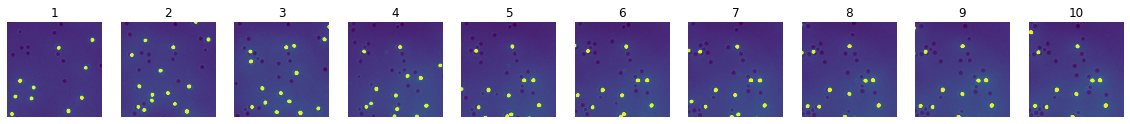

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage import color
import pims
import trackpy as tp
from pandas import DataFrame, Series  # for convenience

@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel

frames = gray(pims.open(r'C:\Users\zackc\Dropbox\cheme599 spring 2020\TimeCourse_NoLeakage\*.tif')) # asterisk opens all tifs in that folder
fig, ax= plt.subplots(1,10,figsize=(20,20))
for i in range(10):
    ax[i].imshow(np.array(frames[i]))
    ax[i].axis('off')
    ax[i].set_title(str(i+1))

In [2]:
def plot_objects(objects, ax, color1):
    # plot the coordinates for each object
    # objects = list of tuples.  Each tuple in objects corresponds to one of the bright spots, and that tuple contains 2 arrays.  The first array contains the Xpositions, and the second array contains the Ypositions, of pixels within that object.
    # ax = axis on which to plot
    # color1 = color of the scatter plot
    for objI in objects:
        ax.scatter(objI[1],objI[0],color=color1,s=.5)
        
def find_coords (x_list, y_list, r_list):
    # Inputs:
    # Given the centers and radii for a set of blobs, find the coordinates for every point within the blob
    # x_list= Xpositions for centers of the blobs
    # y_list= Ypositions for centers of th blobs
    # r_list= radii of the blobs
    # so x_list[0]= Xposition of center of first blob, y_list[0]= Yposition of center of first blob, r_list[0]= radius of first blob
    
    # Outputs:
    # objects = list of tuples.  Each tuple in objects corresponds to one of the bright spots, and that tuple contains 2 lists.  The first list contains the Xpositions, and the second list contains the Ypositions, of pixels within that object.
    
    objects=[]
    
    for i in range(len(x_list)):
        a=x_list[i]
        b=y_list[i]
        r=r_list[i]
        x_vals_in_square= range(int(np.round(a-r)),int(np.round(a+r))+1)
        y_vals_in_square= range(int(np.round(b-r)),int(np.round(b+r))+1)
        x_vals_in_blob=[]
        y_vals_in_blob=[]
        for xI in x_vals_in_square:
            for yI in y_vals_in_square:
                if (xI-a)**2 + (yI-b)**2 <= r**2:
                    x_vals_in_blob.append(xI)
                    y_vals_in_blob.append(yI)
        objects.append((x_vals_in_blob,y_vals_in_blob))
    return(objects)

In [3]:
# Method 1: segmentation

def find_bright_spots2(img2,lower = 0.95, upper = 0.01):
    # Short summary: Find the (x,y) positions for every point within each bright ball in an image
    
    # Extended summary: Take an image, and identify all the bright balls (dyed aqeous regions).  Then return the positions for all pixels within each ball
    # Adapted from -->  https://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html
    
    
    # Parameters
    #   img2 = 2d array with pixel values between 0 and 255
    #   lower = the fraction of pixels that certainly correspond to the background
    #   upper = the fraction of pixels that certainly correspond to the bright dots

    # Returns
    #   objects = list of tuples.  Each tuple in objects corresponds to one of the bright spots, and that tuple contains 2 arrays.  The first array contains the Xpositions, and the second array contains the Ypositions, of pixels within that object.
    
    upper1=1-upper
    
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    from skimage.filters import sobel
    from skimage.segmentation import watershed
    from scipy.ndimage import label, generate_binary_structure
    from skimage.color import label2rgb
    from scipy import ndimage as ndi
    
    total_pixel_number=np.shape(img2)[0]*np.shape(img2)[1]
    hist,bins= np.histogram(img2,bins=np.linspace(np.min(img2),np.max(img2),32))
    background_thresh= bins[np.argmax(np.cumsum(hist/total_pixel_number)>lower)] #find pxel intensity value that (lower*100)% of pixels are <=
    bright_thresh=bins[np.argmax(np.cumsum(hist/total_pixel_number)> upper1)] #find pxel intensity value that (upper*100)% of pixels are <=
    
    markers = np.zeros_like(img2)
    markers[img2 < background_thresh] = 1
    markers[img2 > bright_thresh] = 2
    elevation_map = sobel(img2)
    segmentation = watershed(elevation_map, markers)
    segmentation = ndi.binary_fill_holes(segmentation - 1)
    labeled_coins, _ = ndi.label(segmentation)

    #objects=[] # objects is a list of lists.  Each list in objects corresponds to one of the bright spots, and that list contains many tuples.  Each tuple corresponds to one of the positions (x,y) within that object.
    #for obj1 in range(1,np.max(labeled_coins)+1):
    #    objects.append([])
    #    all_positions=np.nonzero(labeled_coins==obj1) # all_positions is a tuple containing 2 arrays.  The first array is Xpsoitions of each point in obj1, second array is Ypositions.
    #    for point1 in range(len(all_positions[0])):
    #        position1=(all_positions[0][point1],all_positions[1][point1])
    #        objects[obj1-1].append(position1)

    objects=[]
    for obj1 in range(1,np.max(labeled_coins)+1):
        objects.append(np.nonzero(labeled_coins==obj1)) # np.nonzero returns a tuple containing 2 arrays.  The first array is Xpositions of each point in obj1, second array is Ypositions.
    return(objects)

In [4]:
def integrate_brightness(tuple_in,original_image):
    #   tuple_in = A single tuple that contains 2 arrays.  The first array contains the Xpositions, and the second array contains the Ypositions, of pixels within the bright dot that the tuple corresponds to
    #   original_image= np.array of pixel intensities
    
    X_list=tuple_in[1]
    Y_list=tuple_in[0]
    total_intensity=0
    pixel_num=0
    for iindex in range(len(X_list)):
        xI=X_list[iindex]
        yI=Y_list[iindex]
        total_intensity+=original_image[xI,yI]
        pixel_num+=1
    return([total_intensity,pixel_num])

In [18]:
def find_particles_in_every_frame(min_frame,max_frame):
    #select range of frames to use with trackpy
    frames_range=frames[min_frame:max_frame]

    # Run trackpy to generate trajectories for each particle.  Then pick out the individual trajectory for our particle of interest
    f = tp.batch(frames_range, 51,minmass=1e7)
    traj = tp.link(f, 100, memory=0)

    from collections import Counter
    z=Counter(np.array(traj['particle']))
    print('particles present in every frame= '+str([k for k,v in z.items() if v == max(z.values())]))
    return(traj)

In [34]:
def brightness_through_frames(particle_choice, traj):
    individual_trajectory=traj[traj['particle']==particle_choice]
    final_objs=[]

    # Iterate through each frame, and find XY position of the center of our particle in each frame
    for frameI in range(min(traj['frame']),max(traj['frame'])+1):
        Xposition_raw=np.array(individual_trajectory[individual_trajectory['frame']==frameI]['x'])
        Yposition_raw=np.array(individual_trajectory[individual_trajectory['frame']==frameI]['y'])
        Xposition=np.round(Xposition_raw[0])
        Yposition=np.round(Yposition_raw[0])

        # now run my edge-based detection algorithm on this frame.  Of the objects I detect with this edge-based method, which one includes the XY position from trackpy
        objects_method1=find_bright_spots2(np.array(frames[frameI]),lower = 0.95, upper = 0.01) #   objects = list of tuples.  Each tuple in objects corresponds to one of the bright spots, and that tuple contains 2 arrays.  The first array contains the Xpositions, and the second array contains the Ypositions, of pixels within that object.
        COUNTER=0 ##DELETE THIS LINE
        for objectI in objects_method1:
            Y_possibilities=objectI[0]
            X_possibilities=objectI[1]
            X_matches=np.where(X_possibilities==Xposition)
            if Yposition in Y_possibilities[X_matches]:
                # Now that I've found the object of interest, I have all the pixel locations in the object of interest.  objectI=(X,Y) where X and Y are lists of all X and Y position coordinates, respectively
                final_objs.append(objectI)
                break

    fig, ax= plt.subplots(1,len(range(min(traj['frame']),max(traj['frame'])+1)),figsize=(20,20))
    brightness_list=[]
    area_list=[]
    ax_count=0
    for frameI2 in range(min(traj['frame']),max(traj['frame'])+1):
        ax[ax_count].imshow(frames[frameI2],cmap='gray')
        plot_objects([final_objs[ax_count]], ax[ax_count],'yellow')
        ax[ax_count].set_title(str(frameI2))
        output=integrate_brightness(final_objs[ax_count],np.array(frames[frameI2]))
        brightness_list.append(output[0])
        area_list.append(output[1])
        ax_count+=1

    fig1, ax1= plt.subplots(1,2,figsize=(10,10))
    ax1[0].set_ylabel('Bright Intensity')
    ax1[0].set_xlabel('Frames')
    ax1[0].plot(range(min(traj['frame']),max(traj['frame'])+1),brightness_list)
    ax1[1].set_ylabel('Bright Area')
    ax1[1].set_xlabel('Frame')
    ax1[1].plot(range(min(traj['frame']),max(traj['frame'])+1),area_list)

In [31]:
traj=find_particles_in_every_frame(6,16)

Frame 15: 8 trajectories present.
particles present in every frame= [0, 2, 3, 4, 5, 6]


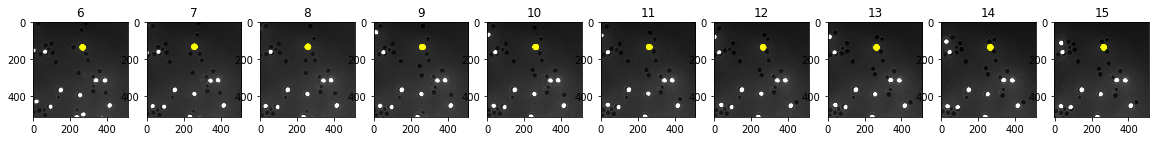

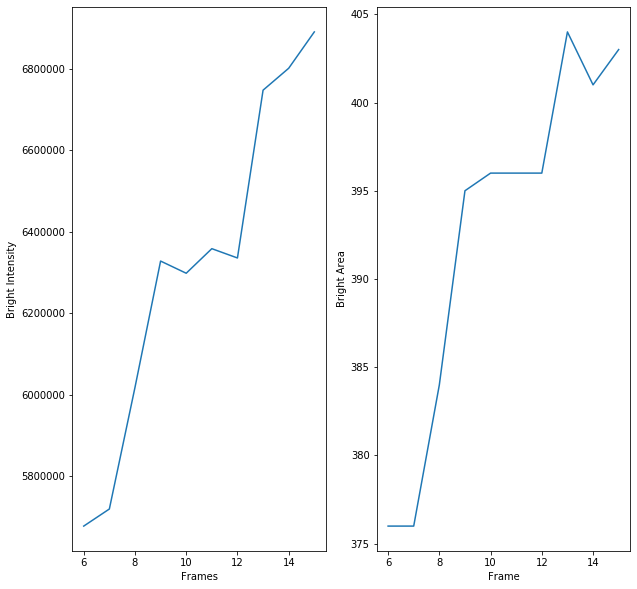

In [36]:
brightness_through_frames(0,traj)